<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Técnicas de Inteligencia Artificial</header1></center>
<left><h1>Actividad 2. Trabajando con redes neuronales y Deep Learning</header1></left>

Presentado por: Ibai Ceberio Basañez  <br>
Fecha: 30/05/2022

# Importación de librerias necesarias

# Parte II. Clasificación

In [66]:
#Para esta actividad se importarán las siguientes librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from keras.models import Sequential
from keras.layers import Dense



from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap

## Cargar el Dataset



In [9]:
#Código para cargar el Dataset
url = 'https://raw.githubusercontent.com/ibai4119/Laboratorio_2/main/students_adaptability_level_online_education.csv'
dataset = pd.read_csv(url)

## Descripción de la fuente del Dataset

El dataset describe la capacidad de adaptación de alumnos a técnicas de enseñanza online.

## Problema a resolver.



## Caracterización del Dataset


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


In [11]:
dataset.describe()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
count,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205,1205
unique,2,6,3,2,2,2,2,3,2,3,3,2,3,3
top,Boy,21-25,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
freq,663,374,530,823,901,935,1004,878,695,775,840,995,1013,625


In [13]:
dataset.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


In [15]:
dataset.columns

Index(['Gender', 'Age', 'Education Level', 'Institution Type', 'IT Student',
       'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
       'Network Type', 'Class Duration', 'Self Lms', 'Device',
       'Adaptivity Level'],
      dtype='object')

## Preprocesamiento del dataset. Transformaciones previas necesarias para la modelación

Como hemos podido observar la mayoría de los datos contienen strings por lo que será necesario codificarlos. De esta manera, convertiremos valores cualitativos en valores numéricos.

Por otro lado, cambiaremos el nombre de alguna columna para su mejor entendimiento.

In [21]:
dataset.rename(columns = {'Adaptivity Level':'Adaptivity'},inplace = True)
dataset.rename(columns = {'Age': 'Age Range'},inplace = True)

dataset.replace("Boy","Male",inplace=True)
dataset.replace("Girl","Female",inplace=True)
dataset.replace("Mid","Middle Class",inplace=True)
dataset.replace("Poor","Lower Class",inplace=True)
dataset.replace("Rich","Upper Class",inplace=True)

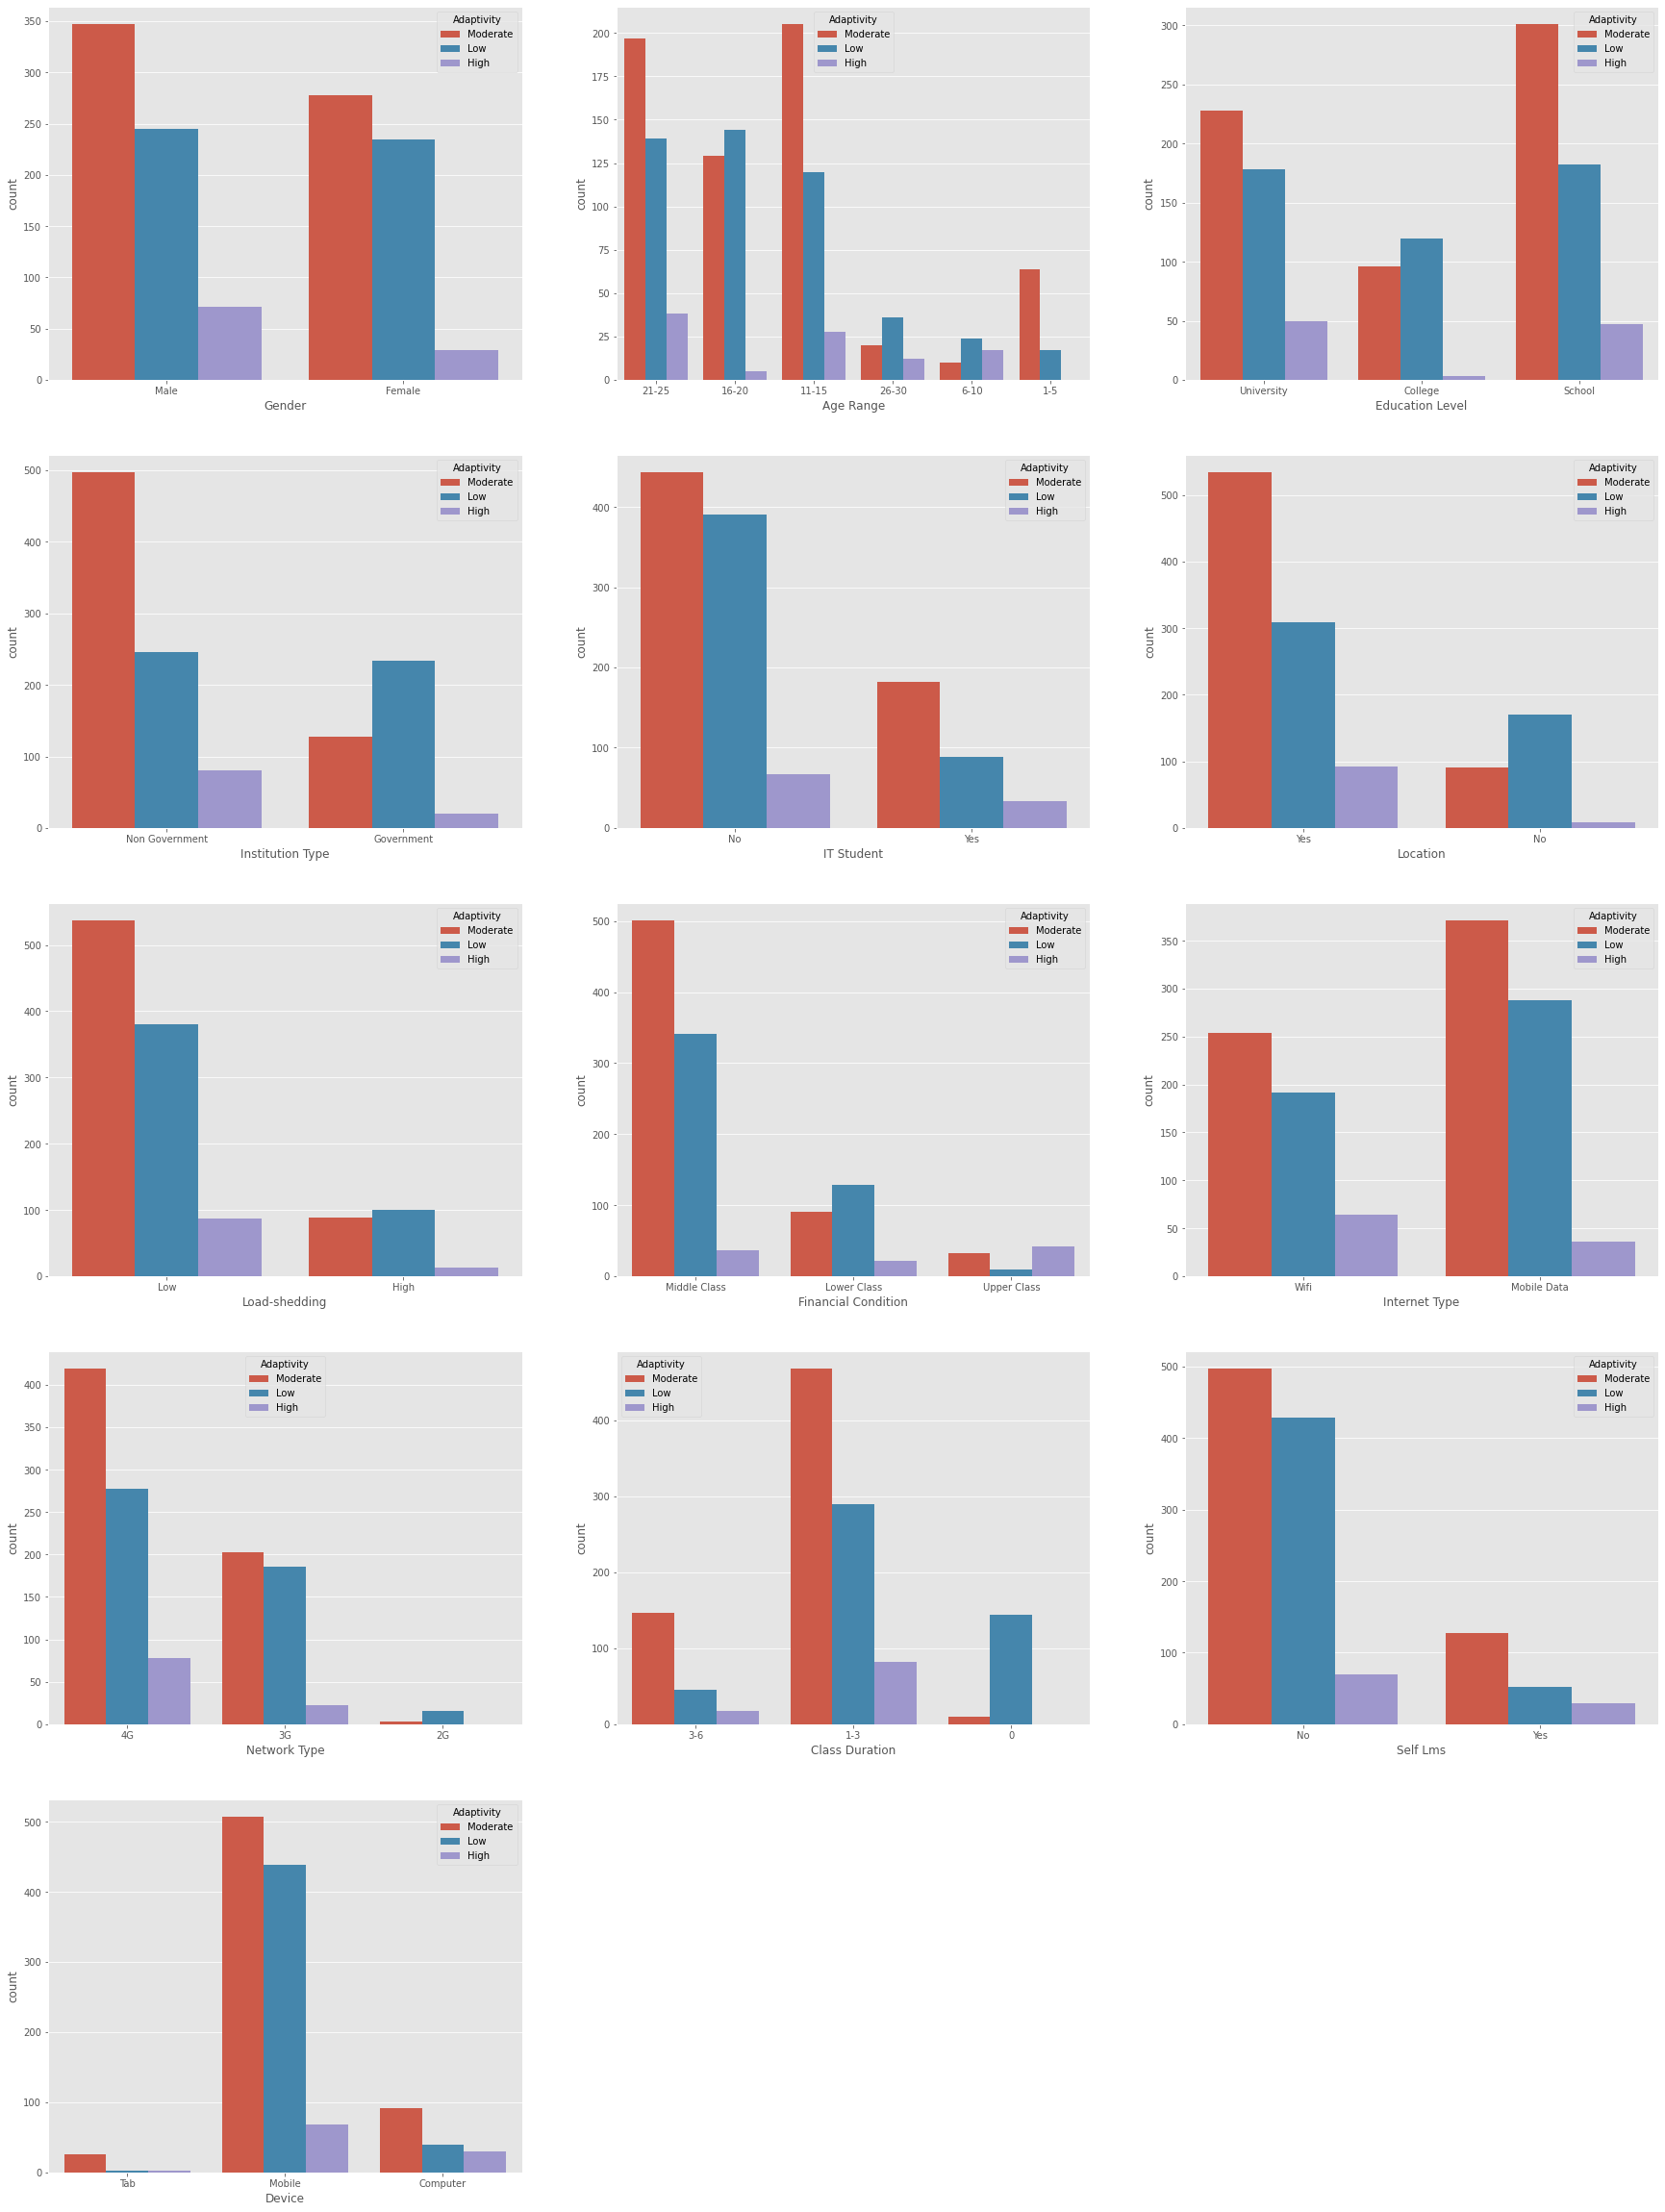

In [24]:
i = 1
plt.figure(figsize = (30,50))
for feature in [col for col in dataset.columns if col!='Adaptivity' ]:
    plt.subplot(6,3,i),
    sns.countplot(x = feature , hue='Adaptivity', data = dataset)

    i +=1

Como la edad viene por rangos en un string, python automaticamente los ordena por orden alfabético. Para ordenarlos numericamente, se coge el valor minimo de cada rango.

In [26]:
#since the age comes as a range and is a string, python will automatically sort by alphabetical order
#to be able to sort numerically,id split the range and use the lower limit instead 
col1 = dataset["Age Range"].apply(lambda x: x.split("-")[0])
data = dataset.join(col1.to_frame(name="Lower limit Age"))
data.drop(['Age Range'], axis = 1, inplace = True)
data.head()

,Gender,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity,Lower limit Age
0,Male,University,Non Government,No,Yes,Low,Middle Class,Wifi,4G,3-6,No,Tab,Moderate,21
1,Female,University,Non Government,No,Yes,High,Middle Class,Mobile Data,4G,1-3,Yes,Mobile,Moderate,21
2,Female,College,Government,No,Yes,Low,Middle Class,Wifi,4G,1-3,No,Mobile,Moderate,16
3,Female,School,Non Government,No,Yes,Low,Middle Class,Mobile Data,4G,1-3,No,Mobile,Moderate,11
4,Female,School,Non Government,No,Yes,Low,Lower Class,Mobile Data,3G,0,No,Mobile,Low,16


In [ ]:
# Convirtiendo en valores de tipo integer
data['Lower limit Age'] = data['Lower limit Age'].astype(int)

In [27]:
scaler = OrdinalEncoder()
names = data.columns
d = scaler.fit_transform(data)

scaled_data = pd.DataFrame(d, columns=names)
scaled_data.head(10)

,Gender,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity,Lower limit Age
0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,2.0,3.0
1,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,3.0
2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,2.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
5,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0
7,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0
8,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,2.0
9,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0


In [31]:
scaled_data.columns

Index(['Gender', 'Education Level', 'Institution Type', 'IT Student',
       'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
       'Network Type', 'Class Duration', 'Self Lms', 'Device', 'Adaptivity',
       'Lower limit Age'],
      dtype='object')

## División del dataset en datos de entrenamiento y datos de test 

Se ha dividido el dataset en un 80% de entrenamiento y un 20% de test.

Al mismo tiempo el dataset se ha normalizado al utilizar el Ordinal Encoder.

In [47]:

features = ['Gender', 'Education Level', 'Institution Type', 'IT Student',
        'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
        'Network Type', 'Class Duration', 'Self Lms', 'Device',
        'Lower limit Age']
X = scaled_data.loc[:, features]
y = scaled_data[['Adaptivity']]

normed_X_data = normalize(X)
normed_y_data = normalize(y)

X_train, X_test, y_train, y_test = train_test_split(normed_X_data, normed_y_data, random_state=0, train_size = .8)

## Propuesta de arquitectura de red neuronal

En keras, un callback es una función que nos permite parar el entrenamiento de un modelo en cualquier momento. Cuando utilizamos early stopping, podemos elegir una cantidad grande de epochs, más de los que necesitamos.

Podemos añadir capas de dropout para corregir el overfitting. Si dejamos caer una fracción de la capa en cada paso del entrenamiento conseguimos que sea mucho más complicado que el modelo aprenda patrones inadecuados y obligamos al modelo a buscar los patrones más generales. Estos patrones suelen tener pesos mayores.

##  Ajuste de modelo de Clasificación RNA

In [40]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [41]:
#Definiendo callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=50, # cuantos epochs esperar
    min_delta=0.001, # cambio mínimo para considerarse mejora
    restore_best_weights=True,
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

## Evaluación de modelo RNA


Minimum Validation Loss: 0.0182
Minimum Validation MAE (mean absolute error): 0.0440


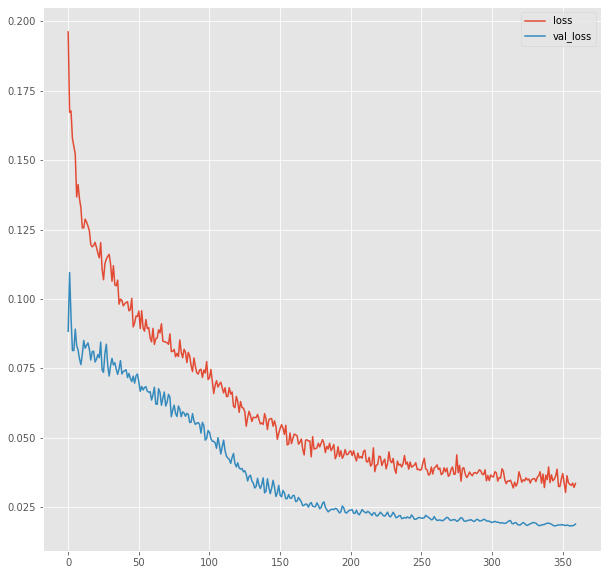

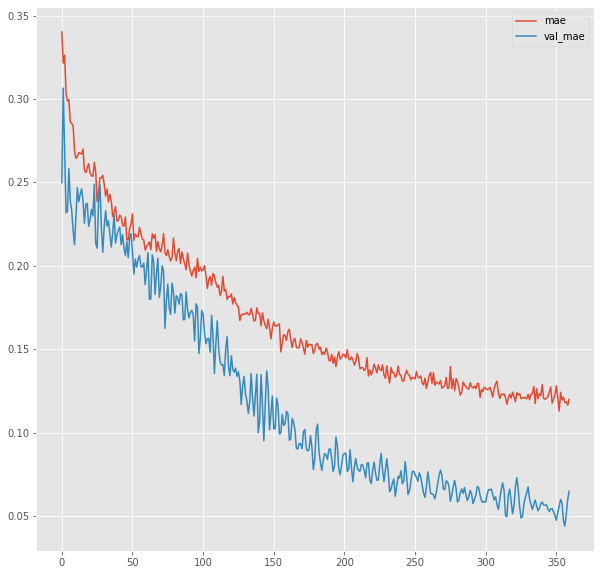

In [43]:
# Training config
EPOCHS = 3000
BATCH_SIZE = 2 ** 8 #256

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_schedule],
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()


print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()))

### Evalúe los resultados  para el conjunto de test.

In [67]:
# Making predictions from test set
predictions = model.predict(X_test)

# Evaluate
model_score = mean_absolute_error(y_test, predictions)
print("Final model score (MAE):", model_score)
print('Final model score (accuracy): ', r2_score(y_test, predictions))

8/8 [==============================] - 0s 436us/step
Final model score (MAE): 0.05389702363380258
Final model score (accuracy):  0.7233203979711158


## Ajuste de modelos de clasificación alternativos

Elige al menos un método de clasificación no basado en redes neuronales (p.ej. regresión logística, árboles de decisión, reglas de clasificación, random forest, SVM, etc).

In [49]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(classification_report(y_test,pred, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88        18
         1.0       0.99      1.00      0.99       223

    accuracy                           0.98       241
   macro avg       0.96      0.91      0.94       241
weighted avg       0.98      0.98      0.98       241



In [60]:
#Building the optimal model using Backward Elimination

X=np.append(arr = np.ones((1205,1)).astype(int), values = X, axis=1)
X_opt=X[:,[0,1,2,3,4,5,7]]
regressor_OLS=sm.OLS(endog=y,exog=X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Adaptivity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 30 May 2022   Prob (F-statistic):                nan
Time:                        16:07:13   Log-Likelihood:                -1175.3
No. Observations:                1205   AIC:                             2353.
Df Residuals:                    1204   BIC:                             2358.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2051      0.003     77.626      0.000       0.200       0.210
x1             0.2051      0.003     77.626      0.000       0.200       0.210
x2             0.2051      0.003     77.626      0.000       0.200       0.210
x3             0.2051      0.003     77.626      0.000       0.200       0.210
x4             0.2051      0.003     77.626      0.000       0.200       0.210
x5             0.2051      0.003     77.626      0.000       0.200       0.210
x6             0.2051      0.003     77.626      0.000       0.200       0.210
==============================================================================
Omnibus:                      107.901   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.654
Skew:                          -0.701   Prob(JB):                     3.45e-25
Kurtosis:                       2.473   Cond. No.                     8.03e+91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-180. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
# Place data into DataFrame for readability
X_test_frame = pd.DataFrame(X_test)
X_test_frame.columns = ['Gender', 'Education Level', 'Institution Type', 'IT Student',
        'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
        'Network Type', 'Class Duration', 'Self Lms', 'Device',
        'Lower limit Age']

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns = ['Gender', 'Education Level', 'Institution Type', 'IT Student',
        'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
        'Network Type', 'Class Duration', 'Self Lms', 'Device',
        'Lower limit Age']

# Summarize the training set to accelerate analysis
X_train_frame = shap.kmeans(X_train_frame.values, 25)

# Instantiate an explainer with the model predictions and training data (or training data summary)
explainer = shap.KernelExplainer(model.predict, X_train_frame)

1/1 [==============================] - 0s 8ms/step


  0%|          | 0/241 [00:00<?, ?it/s]

1621/1621 [==============================] - 1s 391us/step


  0%|          | 1/241 [00:01<04:22,  1.09s/it]

1621/1621 [==============================] - 1s 347us/step


  1%|          | 2/241 [00:02<04:21,  1.10s/it]

1621/1621 [==============================] - 1s 427us/step


  1%|          | 3/241 [00:03<04:19,  1.09s/it]

1621/1621 [==============================] - 1s 377us/step


  2%|▏         | 4/241 [00:04<04:03,  1.03s/it]

1621/1621 [==============================] - 1s 376us/step


  2%|▏         | 5/241 [00:05<04:19,  1.10s/it]

1621/1621 [==============================] - 1s 346us/step


  2%|▏         | 6/241 [00:06<04:14,  1.08s/it]

1621/1621 [==============================] - 1s 347us/step


  3%|▎         | 7/241 [00:07<04:06,  1.05s/it]

1621/1621 [==============================] - 1s 327us/step


  3%|▎         | 8/241 [00:08<04:08,  1.07s/it]

1621/1621 [==============================] - 1s 337us/step


  4%|▎         | 9/241 [00:09<04:05,  1.06s/it]

1621/1621 [==============================] - 1s 347us/step


  4%|▍         | 10/241 [00:10<04:05,  1.06s/it]

1621/1621 [==============================] - 1s 347us/step


  5%|▍         | 11/241 [00:11<03:58,  1.03s/it]

1621/1621 [==============================] - 1s 347us/step


  5%|▍         | 12/241 [00:12<03:52,  1.02s/it]

1621/1621 [==============================] - 1s 365us/step


  5%|▌         | 13/241 [00:13<03:54,  1.03s/it]

1621/1621 [==============================] - 1s 335us/step


  6%|▌         | 14/241 [00:14<03:49,  1.01s/it]

1621/1621 [==============================] - 1s 320us/step


  6%|▌         | 15/241 [00:15<03:51,  1.02s/it]

1621/1621 [==============================] - 1s 350us/step


  7%|▋         | 16/241 [00:16<03:46,  1.00s/it]

1621/1621 [==============================] - 1s 322us/step


  7%|▋         | 17/241 [00:17<03:42,  1.01it/s]

1621/1621 [==============================] - 1s 314us/step


  7%|▋         | 18/241 [00:18<03:41,  1.00it/s]

1621/1621 [==============================] - 1s 304us/step


  8%|▊         | 19/241 [00:19<03:36,  1.03it/s]

1621/1621 [==============================] - 1s 338us/step


  8%|▊         | 20/241 [00:20<03:49,  1.04s/it]

1621/1621 [==============================] - 1s 340us/step


  9%|▊         | 21/241 [00:21<03:49,  1.04s/it]

1621/1621 [==============================] - 1s 346us/step


  9%|▉         | 22/241 [00:22<03:50,  1.05s/it]

1621/1621 [==============================] - 1s 345us/step


 10%|▉         | 23/241 [00:23<03:43,  1.02s/it]

1621/1621 [==============================] - 1s 312us/step


 10%|▉         | 24/241 [00:24<03:45,  1.04s/it]

1621/1621 [==============================] - 1s 344us/step


 10%|█         | 25/241 [00:25<03:36,  1.00s/it]

1621/1621 [==============================] - 1s 336us/step


 11%|█         | 26/241 [00:26<03:46,  1.05s/it]

1621/1621 [==============================] - 1s 338us/step


 11%|█         | 27/241 [00:28<03:47,  1.06s/it]

1621/1621 [==============================] - 1s 401us/step


 12%|█▏        | 28/241 [00:29<03:42,  1.04s/it]

1621/1621 [==============================] - 1s 315us/step


 12%|█▏        | 29/241 [00:30<03:46,  1.07s/it]

1621/1621 [==============================] - 1s 357us/step


 12%|█▏        | 30/241 [00:31<03:35,  1.02s/it]

1621/1621 [==============================] - 1s 320us/step


 13%|█▎        | 31/241 [00:32<03:28,  1.01it/s]

1621/1621 [==============================] - 1s 353us/step


 13%|█▎        | 32/241 [00:33<03:36,  1.03s/it]

1621/1621 [==============================] - 1s 330us/step


 14%|█▎        | 33/241 [00:34<03:36,  1.04s/it]

1621/1621 [==============================] - 1s 350us/step


 14%|█▍        | 34/241 [00:35<03:33,  1.03s/it]

1621/1621 [==============================] - 1s 306us/step


 15%|█▍        | 35/241 [00:36<03:25,  1.00it/s]

1621/1621 [==============================] - 1s 319us/step


 15%|█▍        | 36/241 [00:37<03:31,  1.03s/it]

1621/1621 [==============================] - 1s 355us/step


 15%|█▌        | 37/241 [00:38<03:31,  1.04s/it]

1621/1621 [==============================] - 1s 333us/step


 16%|█▌        | 38/241 [00:39<03:35,  1.06s/it]

1621/1621 [==============================] - 1s 348us/step


 16%|█▌        | 39/241 [00:40<03:34,  1.06s/it]

1621/1621 [==============================] - 1s 341us/step


 17%|█▋        | 40/241 [00:41<03:27,  1.03s/it]

1621/1621 [==============================] - 1s 330us/step


 17%|█▋        | 41/241 [00:42<03:27,  1.04s/it]

1621/1621 [==============================] - 1s 369us/step


 17%|█▋        | 42/241 [00:43<03:22,  1.02s/it]

1621/1621 [==============================] - 1s 619us/step


 18%|█▊        | 43/241 [00:44<03:42,  1.12s/it]

1621/1621 [==============================] - 1s 439us/step


 18%|█▊        | 44/241 [00:45<03:37,  1.11s/it]

1621/1621 [==============================] - 1s 472us/step


 19%|█▊        | 45/241 [00:47<03:36,  1.11s/it]

1621/1621 [==============================] - 1s 458us/step


 19%|█▉        | 46/241 [00:48<03:33,  1.10s/it]

1621/1621 [==============================] - 1s 420us/step


 20%|█▉        | 47/241 [00:49<03:30,  1.09s/it]

1621/1621 [==============================] - 1s 476us/step


 20%|█▉        | 48/241 [00:50<03:32,  1.10s/it]

1621/1621 [==============================] - 1s 488us/step


 20%|██        | 49/241 [00:51<03:38,  1.14s/it]

1621/1621 [==============================] - 1s 372us/step


 21%|██        | 50/241 [00:52<03:34,  1.12s/it]

1621/1621 [==============================] - 1s 298us/step


 21%|██        | 51/241 [00:53<03:30,  1.11s/it]

1621/1621 [==============================] - 1s 309us/step


 22%|██▏       | 52/241 [00:54<03:28,  1.10s/it]

1621/1621 [==============================] - 1s 335us/step


 22%|██▏       | 53/241 [00:55<03:28,  1.11s/it]

1621/1621 [==============================] - 1s 356us/step


 22%|██▏       | 54/241 [00:56<03:26,  1.10s/it]

1621/1621 [==============================] - 1s 397us/step


 23%|██▎       | 55/241 [00:57<03:15,  1.05s/it]

1621/1621 [==============================] - 1s 327us/step


 23%|██▎       | 56/241 [00:59<03:18,  1.08s/it]

1621/1621 [==============================] - 1s 347us/step


 24%|██▎       | 57/241 [01:00<03:16,  1.07s/it]

1621/1621 [==============================] - 1s 352us/step


 24%|██▍       | 58/241 [01:01<03:16,  1.07s/it]

1621/1621 [==============================] - 1s 376us/step


 24%|██▍       | 59/241 [01:02<03:13,  1.06s/it]

1621/1621 [==============================] - 1s 319us/step


 25%|██▍       | 60/241 [01:03<03:16,  1.09s/it]

1621/1621 [==============================] - 1s 351us/step


 25%|██▌       | 61/241 [01:04<03:08,  1.05s/it]

1621/1621 [==============================] - 1s 338us/step


 26%|██▌       | 62/241 [01:05<03:07,  1.05s/it]

1621/1621 [==============================] - 1s 348us/step


 26%|██▌       | 63/241 [01:06<03:11,  1.08s/it]

1621/1621 [==============================] - 1s 346us/step


 27%|██▋       | 64/241 [01:07<03:12,  1.09s/it]

1621/1621 [==============================] - 1s 346us/step


 27%|██▋       | 65/241 [01:08<03:10,  1.08s/it]

1621/1621 [==============================] - 1s 343us/step


 27%|██▋       | 66/241 [01:09<03:09,  1.08s/it]

1621/1621 [==============================] - 1s 326us/step


 28%|██▊       | 67/241 [01:10<03:07,  1.07s/it]

1621/1621 [==============================] - 1s 332us/step


 28%|██▊       | 68/241 [01:11<03:05,  1.07s/it]

1621/1621 [==============================] - 1s 359us/step


 29%|██▊       | 69/241 [01:12<02:58,  1.04s/it]

1621/1621 [==============================] - 1s 313us/step


 29%|██▉       | 70/241 [01:13<02:57,  1.04s/it]

1621/1621 [==============================] - 1s 323us/step


 29%|██▉       | 71/241 [01:14<02:51,  1.01s/it]

1621/1621 [==============================] - 1s 306us/step


 30%|██▉       | 72/241 [01:15<02:54,  1.03s/it]

1621/1621 [==============================] - 1s 349us/step


 30%|███       | 73/241 [01:17<02:55,  1.05s/it]

1621/1621 [==============================] - 1s 380us/step


 31%|███       | 74/241 [01:18<02:58,  1.07s/it]

1621/1621 [==============================] - 1s 352us/step


 31%|███       | 75/241 [01:19<02:56,  1.06s/it]

1621/1621 [==============================] - 1s 352us/step


 32%|███▏      | 76/241 [01:20<02:56,  1.07s/it]

1621/1621 [==============================] - 1s 363us/step


 32%|███▏      | 77/241 [01:21<02:57,  1.08s/it]

1621/1621 [==============================] - 1s 415us/step


 32%|███▏      | 78/241 [01:22<02:57,  1.09s/it]

1621/1621 [==============================] - 1s 320us/step


 33%|███▎      | 79/241 [01:23<02:54,  1.08s/it]

1621/1621 [==============================] - 1s 488us/step


 33%|███▎      | 80/241 [01:24<03:02,  1.13s/it]

1621/1621 [==============================] - 1s 467us/step


 34%|███▎      | 81/241 [01:26<03:07,  1.17s/it]

1621/1621 [==============================] - 1s 315us/step


 34%|███▍      | 82/241 [01:26<02:55,  1.10s/it]

1621/1621 [==============================] - 1s 342us/step


 34%|███▍      | 83/241 [01:28<02:52,  1.09s/it]

1621/1621 [==============================] - 1s 394us/step


 35%|███▍      | 84/241 [01:29<02:57,  1.13s/it]

1621/1621 [==============================] - 1s 352us/step


 35%|███▌      | 85/241 [01:30<02:54,  1.12s/it]

1621/1621 [==============================] - 1s 401us/step


 36%|███▌      | 86/241 [01:31<02:44,  1.06s/it]

1621/1621 [==============================] - 1s 491us/step


 36%|███▌      | 87/241 [01:32<02:45,  1.07s/it]

1621/1621 [==============================] - 1s 381us/step


 37%|███▋      | 88/241 [01:33<02:39,  1.04s/it]

1621/1621 [==============================] - 0s 291us/step


 37%|███▋      | 89/241 [01:34<02:40,  1.06s/it]

1621/1621 [==============================] - 1s 365us/step


 37%|███▋      | 90/241 [01:35<02:40,  1.06s/it]

1621/1621 [==============================] - 1s 321us/step


 38%|███▊      | 91/241 [01:36<02:40,  1.07s/it]

1621/1621 [==============================] - 1s 348us/step


 38%|███▊      | 92/241 [01:37<02:39,  1.07s/it]

1621/1621 [==============================] - 1s 328us/step


 39%|███▊      | 93/241 [01:38<02:37,  1.07s/it]

1621/1621 [==============================] - 1s 330us/step


 39%|███▉      | 94/241 [01:39<02:32,  1.04s/it]

1621/1621 [==============================] - 1s 333us/step


 39%|███▉      | 95/241 [01:40<02:25,  1.00it/s]

1621/1621 [==============================] - 1s 302us/step


 40%|███▉      | 96/241 [01:41<02:24,  1.00it/s]

1621/1621 [==============================] - 1s 312us/step


 40%|████      | 97/241 [01:42<02:19,  1.03it/s]

1621/1621 [==============================] - 0s 277us/step


 41%|████      | 98/241 [01:43<02:26,  1.02s/it]

1621/1621 [==============================] - 1s 349us/step


 41%|████      | 99/241 [01:44<02:23,  1.01s/it]

1621/1621 [==============================] - 1s 341us/step


 41%|████▏     | 100/241 [01:45<02:20,  1.01it/s]

1621/1621 [==============================] - 1s 347us/step


 42%|████▏     | 101/241 [01:46<02:20,  1.00s/it]

1621/1621 [==============================] - 1s 320us/step


 42%|████▏     | 102/241 [01:47<02:16,  1.02it/s]

1621/1621 [==============================] - 0s 303us/step


 43%|████▎     | 103/241 [01:48<02:21,  1.03s/it]

1621/1621 [==============================] - 1s 339us/step


 43%|████▎     | 104/241 [01:49<02:20,  1.02s/it]

1621/1621 [==============================] - 1s 361us/step


 44%|████▎     | 105/241 [01:50<02:25,  1.07s/it]

1621/1621 [==============================] - 1s 352us/step


 44%|████▍     | 106/241 [01:51<02:19,  1.03s/it]

1621/1621 [==============================] - 1s 345us/step


 44%|████▍     | 107/241 [01:52<02:14,  1.00s/it]

1621/1621 [==============================] - 1s 330us/step


 45%|████▍     | 108/241 [01:53<02:16,  1.03s/it]

1621/1621 [==============================] - 1s 327us/step


 45%|████▌     | 109/241 [01:54<02:18,  1.05s/it]

1621/1621 [==============================] - 1s 347us/step


 46%|████▌     | 110/241 [01:56<02:18,  1.06s/it]

1621/1621 [==============================] - 1s 333us/step


 46%|████▌     | 111/241 [01:57<02:17,  1.06s/it]

1621/1621 [==============================] - 1s 389us/step


 46%|████▋     | 112/241 [01:58<02:18,  1.08s/it]

1621/1621 [==============================] - 1s 340us/step


 47%|████▋     | 113/241 [01:59<02:15,  1.06s/it]

1621/1621 [==============================] - 1s 326us/step


 47%|████▋     | 114/241 [02:00<02:13,  1.05s/it]

1621/1621 [==============================] - 1s 337us/step


 48%|████▊     | 115/241 [02:01<02:10,  1.04s/it]

1621/1621 [==============================] - 1s 334us/step


 48%|████▊     | 116/241 [02:02<02:12,  1.06s/it]

1621/1621 [==============================] - 1s 360us/step


 49%|████▊     | 117/241 [02:03<02:08,  1.04s/it]

1621/1621 [==============================] - 1s 391us/step


 49%|████▉     | 118/241 [02:04<02:13,  1.08s/it]

1621/1621 [==============================] - 1s 338us/step


 49%|████▉     | 119/241 [02:05<02:08,  1.05s/it]

1621/1621 [==============================] - 1s 319us/step


 50%|████▉     | 120/241 [02:06<02:07,  1.06s/it]

1621/1621 [==============================] - 1s 350us/step


 50%|█████     | 121/241 [02:07<02:07,  1.06s/it]

1621/1621 [==============================] - 1s 350us/step


 51%|█████     | 122/241 [02:08<02:05,  1.06s/it]

1621/1621 [==============================] - 1s 326us/step


 51%|█████     | 123/241 [02:09<02:03,  1.05s/it]

1621/1621 [==============================] - 1s 316us/step


 51%|█████▏    | 124/241 [02:10<01:56,  1.00it/s]

1621/1621 [==============================] - 1s 354us/step


 52%|█████▏    | 125/241 [02:11<01:56,  1.00s/it]

1621/1621 [==============================] - 1s 348us/step


 52%|█████▏    | 126/241 [02:12<01:49,  1.05it/s]

1621/1621 [==============================] - 1s 336us/step


 53%|█████▎    | 127/241 [02:13<01:50,  1.03it/s]

1621/1621 [==============================] - 0s 300us/step


 53%|█████▎    | 128/241 [02:14<01:50,  1.02it/s]

1621/1621 [==============================] - 1s 332us/step


 54%|█████▎    | 129/241 [02:15<01:54,  1.02s/it]

1621/1621 [==============================] - 1s 347us/step


 54%|█████▍    | 130/241 [02:16<01:54,  1.03s/it]

1621/1621 [==============================] - 1s 338us/step


 54%|█████▍    | 131/241 [02:17<01:54,  1.04s/it]

1621/1621 [==============================] - 1s 302us/step


 55%|█████▍    | 132/241 [02:18<01:49,  1.00s/it]

1621/1621 [==============================] - 1s 334us/step


 55%|█████▌    | 133/241 [02:19<01:51,  1.03s/it]

1621/1621 [==============================] - 1s 315us/step


 56%|█████▌    | 134/241 [02:20<01:49,  1.03s/it]

1621/1621 [==============================] - 1s 354us/step


 56%|█████▌    | 135/241 [02:21<01:49,  1.03s/it]

1621/1621 [==============================] - 1s 373us/step


 56%|█████▋    | 136/241 [02:22<01:47,  1.02s/it]

1621/1621 [==============================] - 1s 323us/step


 57%|█████▋    | 137/241 [02:23<01:43,  1.01it/s]

1621/1621 [==============================] - 1s 327us/step


 57%|█████▋    | 138/241 [02:24<01:42,  1.00it/s]

1621/1621 [==============================] - 1s 321us/step


 58%|█████▊    | 139/241 [02:25<01:44,  1.02s/it]

1621/1621 [==============================] - 1s 382us/step


 58%|█████▊    | 140/241 [02:26<01:44,  1.04s/it]

1621/1621 [==============================] - 1s 322us/step


 59%|█████▊    | 141/241 [02:27<01:40,  1.00s/it]

1621/1621 [==============================] - 1s 382us/step


 59%|█████▉    | 142/241 [02:28<01:43,  1.04s/it]

1621/1621 [==============================] - 1s 384us/step


 59%|█████▉    | 143/241 [02:30<01:46,  1.09s/it]

1621/1621 [==============================] - 1s 348us/step


 60%|█████▉    | 144/241 [02:31<01:42,  1.06s/it]

1621/1621 [==============================] - 1s 338us/step


 60%|██████    | 145/241 [02:32<01:41,  1.06s/it]

1621/1621 [==============================] - 1s 382us/step


 61%|██████    | 146/241 [02:33<01:39,  1.04s/it]

1621/1621 [==============================] - 1s 306us/step


 61%|██████    | 147/241 [02:34<01:36,  1.03s/it]

1621/1621 [==============================] - 1s 326us/step


 61%|██████▏   | 148/241 [02:35<01:36,  1.03s/it]

1621/1621 [==============================] - 1s 351us/step


 62%|██████▏   | 149/241 [02:36<01:35,  1.04s/it]

1621/1621 [==============================] - 1s 342us/step


 62%|██████▏   | 150/241 [02:37<01:36,  1.06s/it]

1621/1621 [==============================] - 1s 364us/step


 63%|██████▎   | 151/241 [02:38<01:34,  1.05s/it]

1621/1621 [==============================] - 1s 380us/step


 63%|██████▎   | 152/241 [02:39<01:33,  1.05s/it]

1621/1621 [==============================] - 1s 330us/step


 63%|██████▎   | 153/241 [02:40<01:29,  1.02s/it]

1621/1621 [==============================] - 1s 330us/step


 64%|██████▍   | 154/241 [02:41<01:28,  1.02s/it]

1621/1621 [==============================] - 1s 325us/step


 64%|██████▍   | 155/241 [02:42<01:30,  1.05s/it]

1621/1621 [==============================] - 1s 326us/step


 65%|██████▍   | 156/241 [02:43<01:27,  1.03s/it]

1621/1621 [==============================] - 1s 349us/step


 65%|██████▌   | 157/241 [02:44<01:26,  1.03s/it]

1621/1621 [==============================] - 1s 318us/step


 66%|██████▌   | 158/241 [02:45<01:26,  1.04s/it]

1621/1621 [==============================] - 1s 374us/step


 66%|██████▌   | 159/241 [02:46<01:24,  1.04s/it]

1621/1621 [==============================] - 1s 330us/step


 66%|██████▋   | 160/241 [02:47<01:23,  1.03s/it]

1621/1621 [==============================] - 1s 331us/step


 67%|██████▋   | 161/241 [02:48<01:23,  1.05s/it]

1621/1621 [==============================] - 1s 361us/step


 67%|██████▋   | 162/241 [02:49<01:21,  1.03s/it]

1621/1621 [==============================] - 1s 353us/step


 68%|██████▊   | 163/241 [02:50<01:23,  1.07s/it]

1621/1621 [==============================] - 1s 377us/step


 68%|██████▊   | 164/241 [02:51<01:23,  1.08s/it]

1621/1621 [==============================] - 1s 354us/step


 68%|██████▊   | 165/241 [02:52<01:19,  1.05s/it]

1621/1621 [==============================] - 1s 336us/step


 69%|██████▉   | 166/241 [02:53<01:16,  1.02s/it]

1621/1621 [==============================] - 1s 330us/step


 69%|██████▉   | 167/241 [02:54<01:15,  1.02s/it]

1621/1621 [==============================] - 1s 372us/step


 70%|██████▉   | 168/241 [02:56<01:16,  1.05s/it]

1621/1621 [==============================] - 1s 353us/step


 70%|███████   | 169/241 [02:56<01:11,  1.00it/s]

1621/1621 [==============================] - 1s 355us/step


 71%|███████   | 170/241 [02:57<01:10,  1.01it/s]

1621/1621 [==============================] - 1s 365us/step


 71%|███████   | 171/241 [02:58<01:08,  1.02it/s]

1621/1621 [==============================] - 1s 381us/step


 71%|███████▏  | 172/241 [02:59<01:05,  1.05it/s]

1621/1621 [==============================] - 0s 280us/step


 72%|███████▏  | 173/241 [03:00<01:01,  1.10it/s]

1621/1621 [==============================] - 1s 306us/step


 72%|███████▏  | 174/241 [03:01<00:58,  1.14it/s]

1621/1621 [==============================] - 0s 237us/step


 73%|███████▎  | 175/241 [03:02<00:58,  1.13it/s]

1621/1621 [==============================] - 1s 308us/step


 73%|███████▎  | 176/241 [03:03<00:55,  1.17it/s]

1621/1621 [==============================] - 0s 284us/step


 73%|███████▎  | 177/241 [03:03<00:53,  1.20it/s]

1621/1621 [==============================] - 1s 328us/step


 74%|███████▍  | 178/241 [03:04<00:52,  1.20it/s]

1621/1621 [==============================] - 1s 308us/step


 74%|███████▍  | 179/241 [03:05<00:50,  1.22it/s]

1621/1621 [==============================] - 0s 290us/step


 75%|███████▍  | 180/241 [03:06<00:49,  1.24it/s]

1621/1621 [==============================] - 0s 288us/step


 75%|███████▌  | 181/241 [03:06<00:47,  1.25it/s]

1621/1621 [==============================] - 1s 309us/step


 76%|███████▌  | 182/241 [03:07<00:46,  1.26it/s]

1621/1621 [==============================] - 0s 286us/step


 76%|███████▌  | 183/241 [03:08<00:46,  1.25it/s]

1621/1621 [==============================] - 0s 302us/step


 76%|███████▋  | 184/241 [03:09<00:45,  1.25it/s]

1621/1621 [==============================] - 1s 302us/step


 77%|███████▋  | 185/241 [03:10<00:44,  1.26it/s]

1621/1621 [==============================] - 0s 300us/step


 77%|███████▋  | 186/241 [03:10<00:43,  1.27it/s]

1621/1621 [==============================] - 0s 297us/step


 78%|███████▊  | 187/241 [03:11<00:42,  1.28it/s]

1621/1621 [==============================] - 1s 330us/step


 78%|███████▊  | 188/241 [03:12<00:42,  1.26it/s]

1621/1621 [==============================] - 0s 284us/step


 78%|███████▊  | 189/241 [03:13<00:41,  1.26it/s]

1621/1621 [==============================] - 1s 305us/step


 79%|███████▉  | 190/241 [03:14<00:40,  1.25it/s]

1621/1621 [==============================] - 1s 305us/step


 79%|███████▉  | 191/241 [03:14<00:39,  1.27it/s]

1621/1621 [==============================] - 0s 298us/step


 80%|███████▉  | 192/241 [03:15<00:38,  1.27it/s]

1621/1621 [==============================] - 1s 335us/step


 80%|████████  | 193/241 [03:16<00:38,  1.25it/s]

1621/1621 [==============================] - 1s 306us/step


 80%|████████  | 194/241 [03:17<00:37,  1.26it/s]

1621/1621 [==============================] - 0s 292us/step


 81%|████████  | 195/241 [03:18<00:36,  1.26it/s]

1621/1621 [==============================] - 0s 286us/step


 81%|████████▏ | 196/241 [03:18<00:35,  1.26it/s]

1621/1621 [==============================] - 1s 311us/step


 82%|████████▏ | 197/241 [03:19<00:35,  1.25it/s]

1621/1621 [==============================] - 0s 297us/step


 82%|████████▏ | 198/241 [03:20<00:34,  1.26it/s]

1621/1621 [==============================] - 1s 305us/step


 83%|████████▎ | 199/241 [03:21<00:33,  1.27it/s]

1621/1621 [==============================] - 1s 327us/step


 83%|████████▎ | 200/241 [03:22<00:32,  1.26it/s]

1621/1621 [==============================] - 0s 276us/step


 83%|████████▎ | 201/241 [03:22<00:31,  1.26it/s]

1621/1621 [==============================] - 1s 306us/step


 84%|████████▍ | 202/241 [03:23<00:30,  1.26it/s]

1621/1621 [==============================] - 1s 321us/step


 84%|████████▍ | 203/241 [03:24<00:30,  1.25it/s]

1621/1621 [==============================] - 0s 289us/step


 85%|████████▍ | 204/241 [03:25<00:29,  1.25it/s]

1621/1621 [==============================] - 0s 304us/step


 85%|████████▌ | 205/241 [03:26<00:28,  1.25it/s]

1621/1621 [==============================] - 0s 270us/step


 85%|████████▌ | 206/241 [03:26<00:28,  1.24it/s]

1621/1621 [==============================] - 1s 329us/step


 86%|████████▌ | 207/241 [03:27<00:27,  1.23it/s]

1621/1621 [==============================] - 1s 316us/step


 86%|████████▋ | 208/241 [03:28<00:26,  1.24it/s]

1621/1621 [==============================] - 1s 317us/step


 87%|████████▋ | 209/241 [03:29<00:25,  1.25it/s]

1621/1621 [==============================] - 1s 334us/step


 87%|████████▋ | 210/241 [03:30<00:25,  1.23it/s]

1621/1621 [==============================] - 1s 313us/step


 88%|████████▊ | 211/241 [03:30<00:24,  1.24it/s]

1621/1621 [==============================] - 1s 296us/step


 88%|████████▊ | 212/241 [03:31<00:23,  1.24it/s]

1621/1621 [==============================] - 1s 350us/step


 88%|████████▊ | 213/241 [03:32<00:23,  1.21it/s]

1621/1621 [==============================] - 1s 545us/step


 89%|████████▉ | 214/241 [03:33<00:25,  1.07it/s]

1621/1621 [==============================] - 1s 617us/step


 89%|████████▉ | 215/241 [03:35<00:27,  1.07s/it]

1621/1621 [==============================] - 1s 379us/step


 90%|████████▉ | 216/241 [03:36<00:26,  1.06s/it]

1621/1621 [==============================] - 1s 374us/step


 90%|█████████ | 217/241 [03:37<00:24,  1.03s/it]

1621/1621 [==============================] - 0s 272us/step


 90%|█████████ | 218/241 [03:38<00:22,  1.02it/s]

1621/1621 [==============================] - 1s 339us/step


 91%|█████████ | 219/241 [03:38<00:20,  1.07it/s]

1621/1621 [==============================] - 1s 329us/step


 91%|█████████▏| 220/241 [03:39<00:18,  1.11it/s]

1621/1621 [==============================] - 0s 300us/step


 92%|█████████▏| 221/241 [03:40<00:17,  1.13it/s]

1621/1621 [==============================] - 1s 325us/step


 92%|█████████▏| 222/241 [03:41<00:16,  1.15it/s]

1621/1621 [==============================] - 1s 324us/step


 93%|█████████▎| 223/241 [03:42<00:15,  1.16it/s]

1621/1621 [==============================] - 1s 327us/step


 93%|█████████▎| 224/241 [03:43<00:14,  1.17it/s]

1621/1621 [==============================] - 0s 300us/step


 93%|█████████▎| 225/241 [03:43<00:13,  1.17it/s]

1621/1621 [==============================] - 1s 412us/step


 94%|█████████▍| 226/241 [03:44<00:13,  1.12it/s]

1621/1621 [==============================] - 0s 297us/step


 94%|█████████▍| 227/241 [03:45<00:12,  1.15it/s]

1621/1621 [==============================] - 1s 322us/step


 95%|█████████▍| 228/241 [03:46<00:11,  1.15it/s]

1621/1621 [==============================] - 1s 323us/step


 95%|█████████▌| 229/241 [03:47<00:10,  1.15it/s]

1621/1621 [==============================] - 1s 295us/step


 95%|█████████▌| 230/241 [03:48<00:09,  1.14it/s]

1621/1621 [==============================] - 1s 316us/step


 96%|█████████▌| 231/241 [03:49<00:08,  1.17it/s]

1621/1621 [==============================] - 1s 319us/step


 96%|█████████▋| 232/241 [03:49<00:07,  1.18it/s]

1621/1621 [==============================] - 0s 302us/step


 97%|█████████▋| 233/241 [03:50<00:06,  1.20it/s]

1621/1621 [==============================] - 1s 327us/step


 97%|█████████▋| 234/241 [03:51<00:05,  1.21it/s]

1621/1621 [==============================] - 1s 330us/step


 98%|█████████▊| 235/241 [03:52<00:05,  1.18it/s]

1621/1621 [==============================] - 0s 299us/step


 98%|█████████▊| 236/241 [03:53<00:04,  1.19it/s]

1621/1621 [==============================] - 1s 304us/step


 98%|█████████▊| 237/241 [03:54<00:03,  1.21it/s]

1621/1621 [==============================] - 0s 302us/step


 99%|█████████▉| 238/241 [03:54<00:02,  1.21it/s]

1621/1621 [==============================] - 1s 311us/step


 99%|█████████▉| 239/241 [03:55<00:01,  1.21it/s]

1621/1621 [==============================] - 1s 298us/step


100%|█████████▉| 240/241 [03:56<00:00,  1.22it/s]

1621/1621 [==============================] - 1s 361us/step


100%|██████████| 241/241 [03:57<00:00,  1.01it/s]


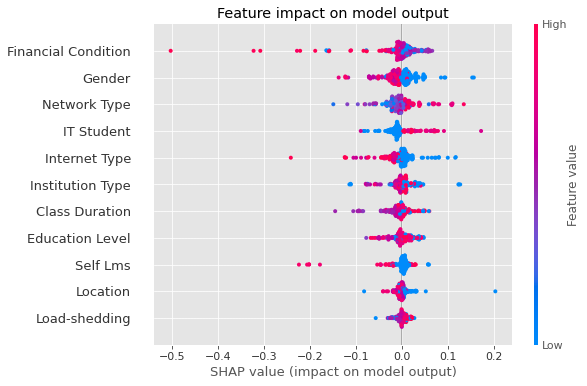

In [63]:
# Extract Shapley values from the explainer
# Select test data representing red wine category
shap_values = explainer.shap_values(X_test_frame[:400])

# Summarize the Shapley values in a plot
plt.title('Feature impact on model output')
shap.summary_plot(shap_values[0][:,:-2], X_test_frame[:400].iloc[:,:-2][:400],max_display=30, show=False)